# Transport properties

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from majordome import (
    MajordomePlot,
    EffectiveThermalConductivity,
    SolutionDimless,
    SutherlandFitting,
    WSGGRadlibBordbar2020,
    bounds
)
from matplotlib import pyplot as plt
import cantera as ct
import numpy as np

## Effective thermal conductivity

Class `EffectiveThermalConductivity` implements static methods for the evaluation of properties; its name is quite long, let's start by getting an alias before evaluating the desired models:

In [3]:
etc = EffectiveThermalConductivity()

Using [Maxwell](https://en.wikipedia.org/wiki/Effective_medium_approximations) approximation, we could estimate the the effective thermal conductivity of a packed bed of particles in a *matrix* of air; assume particles loosly embeded in air and the following properties; the computed effective thermal conductivity is shown to approach the air limit:

In [4]:
phi = 0.30   # Loosely packed solids [30%v]
k_g = 0.025  # Air thermal conductivity [W/(m.K)]
k_s = 1.000  # Solids thermal conductivity [W/(m.K)]

etc.maxwell_garnett(phi, k_g, k_s)

0.05396039603960396

For the limit of high temperatures, it is usually important to account for particle-particle radiation heat transfer; this introduces a $T^3$ dependence on temperature, as one should expect by linearizing Stefan-Boltzmann law.

Please notice that these models compute different things; while Maxwell approximation computes the medium properties (to approximate matrix-inclusion as a single domain), Singh's model accounts only for solids properties. One might wish to combine them (warning: unverified validity!) to evaluate overall medium thermal conductivity. See the references in the class documentation for further discussion, specially the extension proposed by Kiradjiev (2019), which leads to a result similar to the assymptotic behavior displayed below.

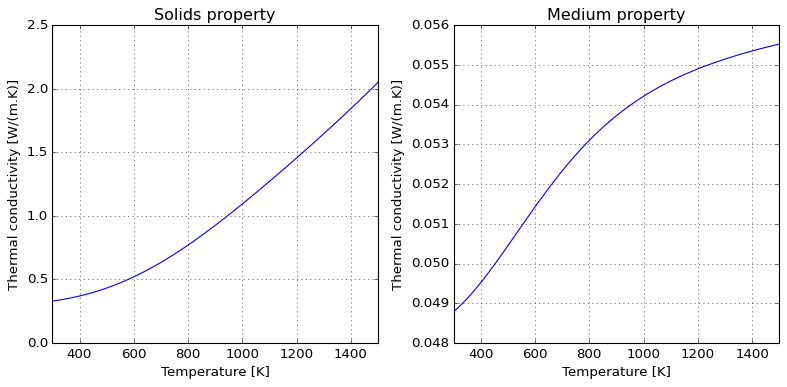

In [5]:
@MajordomePlot.new(shape=(1, 2))
def plot_etc(data, plot=None):
    fig, ax = plot.subplots()
    T, k_s, k_m =  data

    ax[0].plot(T, k_s)
    ax[1].plot(T, k_m)

    ax[0].set_xlim(bounds(T))
    ax[1].set_xlim(bounds(T))

    ax[0].set_title("Solids property")
    ax[1].set_title("Medium property")
    ax[0].set_xlabel("Temperature [K]")
    ax[1].set_xlabel("Temperature [K]")
    ax[0].set_ylabel("Thermal conductivity [W/(m.K)]")
    ax[1].set_ylabel("Thermal conductivity [W/(m.K)]")


d_p = 0.005
eps = 0.9

T = np.linspace(300, 1500, 50)
k_eff_s = etc.singh1994(T, phi, d_p, k_s, eps)
k_eff_m = etc.maxwell_garnett(phi, k_g, k_eff_s)

plot_etc((T, k_eff_s, k_eff_m)).resize(10, 5)

Due to kinetic theory implications, gas thermal conductivity tend to have a positive slope in temperature; the following illustrates how this can be accounted for and the roughly linear behaviour introduced when computing medium properties within air.

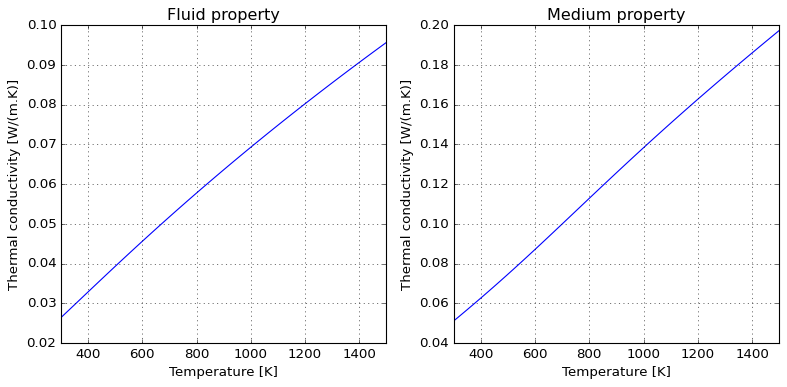

In [6]:
@MajordomePlot.new(shape=(1, 2))
def plot_etc(data, plot=None):
    fig, ax = plot.subplots()
    T, k_g, k_m =  data

    ax[0].plot(T, k_g)
    ax[1].plot(T, k_m)

    ax[0].set_xlim(bounds(T))
    ax[1].set_xlim(bounds(T))

    ax[0].set_title("Fluid property")
    ax[1].set_title("Medium property")
    ax[0].set_xlabel("Temperature [K]")
    ax[1].set_xlabel("Temperature [K]")
    ax[0].set_ylabel("Thermal conductivity [W/(m.K)]")
    ax[1].set_ylabel("Thermal conductivity [W/(m.K)]")


gas = ct.Solution("airish.yaml")
sol = ct.SolutionArray(gas, (T.shape[0],))
sol.TP = T, None

k_gas = sol.thermal_conductivity
k_eff_m = etc.maxwell_garnett(phi, k_gas, k_eff_s)

plot_etc((T, k_gas, k_eff_m)).resize(10, 5)

## Dimensionless numbers

A dimensionless numbers calculator is provided for gas flows; it currently has a certain number of groups which are all evaluated by definition (which might change according to your field, please check the docs). The mechanics of using the class can be resumed to:

1. loading a mechanism file (Cantera YAML)
2. setting the state of the solution
3. evaluating the required properties
4. (optional) displaying a report

The meaning of the tuple of arguments provided to `set_state` is specified by `tuple_name="TPX"`, which defaults to temperature, pressure, and molar proportions. Any triplet allowed by [Cantera](https://cantera.org/stable/python/thermo.html#id3) can be specified here.

In [7]:
Tw = 1000.0  # Wall temperature [K]
U = 10.0     # Characteristic velocity [m/s]
D = 0.05     # Pipe diameter [m]
L = 1.0      # Pipe length [m]

calculator = SolutionDimless("airish.yaml")
calculator.set_state(300.0, 101325.0, "N2: 1", tuple_name="TPX")

Re   = calculator.reynolds(U, D)
Pr   = calculator.prandtl()
Sc   = calculator.schmidt()
print(calculator.report())

--------  ------------  ---------------
Reynolds  31460.9       U=10.0, L=0.05
Prandtl       0.709327
Schmidt       0.761752  mix_diff_coeffs
--------  ------------  ---------------


If you prefer to have direct access to the internal solution, you can set properties as usual in Cantera, but you need to keep in mind to call `update()` to refresh the internal state of the calculator. Every time the properties are updated, the internal buffer of computed dimensionless numbers is refreshed, as you migth notice in the following table.

In [8]:
calculator.solution.TPX = 300.0, 101325.0, "N2: 1"
calculator.update()

Pe_m = calculator.peclet_mass(U, L)
Pe_h = calculator.peclet_heat(U, L)
Gr   = calculator.grashof(Tw, D)
Ra   = calculator.rayleigh(Tw, D)
print(calculator.report())

-------------  ----------------  ------------------------------
Péclet (mass)  479308            U=10.0, L=1.0, mix_diff_coeffs
Péclet (heat)  446321            U=10.0, L=1.0
Grashof             1.13242e+07  Tw=1000.0, H=0.05, g=9.80665
Rayleigh            8.03259e+06  Tw=1000.0, H=0.05, g=9.80665
-------------  ----------------  ------------------------------


## Sutherland fitting

To the author's knowledge, there is no standard tool to convert Cantera transport data to Sutherland parameters for use with OpenFOAM, what led to the motivation to develop `SutherlandFitting`. This simple class wraps a Cantera solution object, which it makes use for fitting Sutherland parameters to export as a table (to be used elswhere), and also allows for retrieving a converted database in OpenFOAM compatible format. The following example should be self-explanatory:

In [9]:
T = np.linspace(500, 2500, 100)

sutherland = SutherlandFitting("airish.yaml")
sutherland.fit(T, species_names=["O2", "N2"])

coef = sutherland.coefs_table
coef

,species,As [uPa.s],Ts [K],RMSE [uPa.s]
0,O2,1.873876,229.321211,0.527484
1,N2,1.619350,226.141806,0.470152


If needed, it is also possible to have direct access to the viscosity data used in parameter fitting:

In [10]:
sutherland.viscosity.head()

,T,O2,N2
0,500.000000,30.045456,26.123142
1,520.202020,30.886884,26.845049
2,540.404040,31.713820,27.554780
3,560.606061,32.527146,28.253075
4,580.808081,33.327662,28.940602


Because RMSE compresses all the error in a single value, you can check graphically where the deviations happen in the interval:

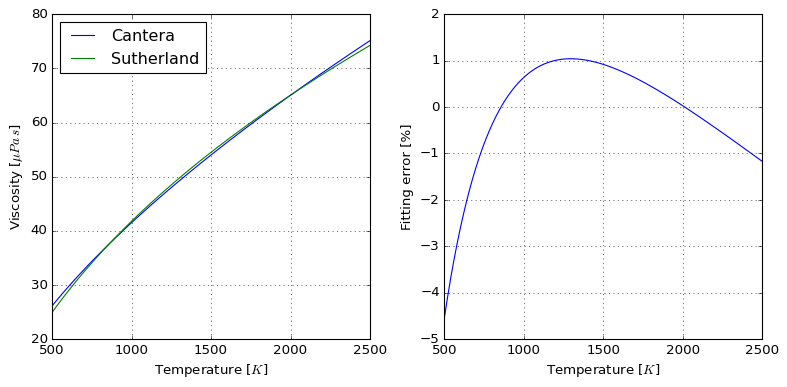

In [11]:
plot = sutherland.plot_species("N2")

Finally, it *also* responds to its initial goal of exporting values in OpenFOAM format:

In [12]:
print(sutherland.to_openfoam())


/* --- RMSE 0.5274842993902649 ---*/
"O2"
{
    transport
    {
        As  1.8738763185e-06;
        Ts  2.2932121082e+02;
    }
}            
/* --- RMSE 0.4701517988286822 ---*/
"N2"
{
    transport
    {
        As  1.6193495479e-06;
        Ts  2.2614180620e+02;
    }
}            


## Radiative properties

The basic usage of the model to estimate total emissivity is done as follows:

In [13]:
model = WSGGRadlibBordbar2020()
model(L=1, T=1000, P=101325, x_h2o=0.18, x_co2=0.08, fvsoot=0.0)

np.float64(0.18368577452587137)

### Validation of Bordbar WSGG implementation

Evaluation of the model against original source of Bordbar (2014) is satisfactory, as follows:

In [14]:
@MajordomePlot.new(shape=(1, 2))
def plot_bordbar2014(_obj, plot=None):
    """ Reproduce plots of Bordbar (2014), Fig. 2. """
    fig, ax = plot.subplots()

    def scan_flue(T, L, *, M):
        x_co2 = 1 / (1 + M)
        return model(L, T, 101325, M*x_co2, x_co2)

    dry_flue = np.vectorize(lambda T, L: scan_flue(T, L, M=1/8))
    wet_flue = np.vectorize(lambda T, L: scan_flue(T, L, M=1/1))

    L = np.asarray([0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 20.0, 60.0])
    T = np.arange(400, 2401, 100)
    sample = np.meshgrid(T, L)

    for n, eps in enumerate(dry_flue(*sample)):
        ax[0].plot(T, eps, label=f"{L[n]} atm.m")

    for n, eps in enumerate(wet_flue(*sample)):
        ax[1].plot(T, eps, label=f"{L[n]} atm.m")

    ax[0].set_title("Dry flue M=1/8")
    ax[1].set_title("Wet flue M=1")

    ax[0].set_xlabel("Temperature [K]")
    ax[1].set_xlabel("Temperature [K]")

    ax[0].set_ylabel("Total emissivity")
    ax[1].set_ylabel("Total emissivity")

    ax[0].set_xlim(400, 2400)
    ax[1].set_xlim(400, 2400)
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 1)

    ax[0].set_xticks(np.arange(400, 2401, 400))
    ax[1].set_xticks(np.arange(400, 2401, 400))

    ax[0].set_yticks(np.arange(0, 1.01, 0.1))
    ax[1].set_yticks(np.arange(0, 1.01, 0.1))

    ax[0].legend(loc=1, fontsize=9)
    ax[1].legend(loc=1, fontsize=9)

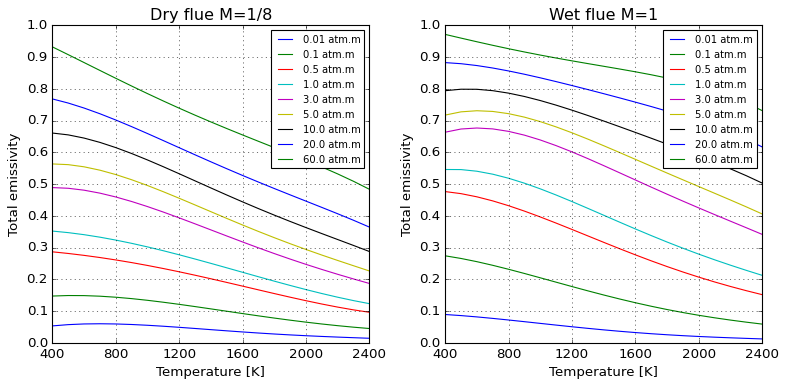

In [15]:
plot_bordbar2014(None).resize(10, 5)

Absorption coefficients for pure substances only reproduce approximately values reported by Bordbar (2020).

In [16]:
model(L=1, T=300, P=101325, x_h2o=0, x_co2=1)
model.absorption_coefs[1:]

array([3.388079e-02, 4.544269e-01, 4.680226e+00, 1.038439e+02])

In [17]:
model(L=1, T=300, P=101325, x_h2o=1, x_co2=0)
model.absorption_coefs[1:]

array([ 0.07703541,  0.8242941 ,  6.854761  , 65.93653   ])

### Application to radiative combustion

Below we illustrate the application of `WSGGRadlibBordbar2020` to predict the emissivity of  $x\mathrm{H_2O}-(1-x)\mathrm{CO_2}$ mixtures over a broad temperature range applicable to the analysis of combustion processes. One observes an important participation of flue gases, especially at lower temperatures.

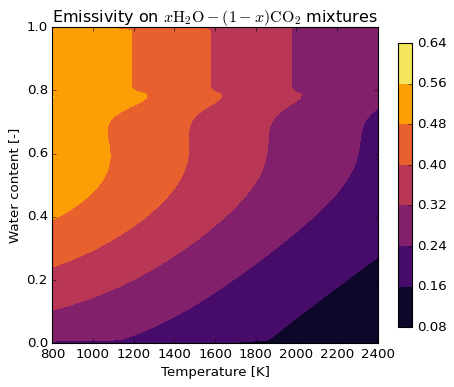

In [18]:
wsgg = WSGGRadlibBordbar2020()

@np.vectorize
def emissivity(T, X, L=1, P=101325):
    return wsgg(L=L, T=T, P=P, x_h2o=X, x_co2=1-X, fvsoot=0.0)

T = np.linspace(800, 2400, 100)
X = np.linspace(0, 1, 100)

xy = np.meshgrid(T, X)
eps = emissivity(*xy)

plt.close("all")
fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
cf = ax.contourf(T, X, eps, cmap="inferno")
cbar = ax.figure.colorbar(cf, ax=ax, shrink=0.9)
ax.set_title(r"Emissivity on $x\mathrm{H_2O}-(1-x)\mathrm{CO_2}$ mixtures")
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Water content [-]")
fig.tight_layout()